# Importing Modules

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
#import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from  sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mlxtend.preprocessing import TransactionEncoder

# Ignore DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Loading Dataset

In [2]:
pip install xlrd

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Loading the mhs dataset in excel format
df = pd.read_csv('mhs1.csv')

#Viewing the first 10 rows 
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [4]:
#Checking for missing values
df.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [5]:
#Summary Statistics
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [6]:
#Check for heartrate less than 60 (detected fake entries)
df[df['HeartRate']<60]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


In [7]:
df.loc[499]

Age                  16
SystolicBP          120
DiastolicBP          75
BS                  7.9
BodyTemp           98.0
HeartRate             7
RiskLevel      low risk
Name: 499, dtype: object

In [8]:
# Calculate the mean of HeartRate
mean_heartrate = df['HeartRate'].mean()

# Change the value of HearRate in index 499 and 908 with the mean HeartRate
df.loc[499, 'HeartRate'] = mean_heartrate
df.loc[908, 'HeartRate'] = mean_heartrate

In [9]:
#Check for heartrate less than 60 (detected fake entries)
df[df['HeartRate']<60]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel


# Exploratory Data Analysis

In [10]:
#encode RiskLevel column into numeral values using LabelEncoder
le = LabelEncoder()

risklevel = le.fit_transform(df['RiskLevel'])
df['RiskLevel'] = risklevel

In [11]:
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86.0,0
1,35,140,90,13.0,98.0,70.0,0
2,29,90,70,8.0,100.0,80.0,0
3,30,140,85,7.0,98.0,70.0,0
4,35,120,60,6.1,98.0,76.0,1
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80.0,0
1010,55,120,90,18.0,98.0,60.0,0
1011,35,85,60,19.0,98.0,86.0,0
1012,43,120,90,18.0,98.0,70.0,0


In [12]:
cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

def plot_histograms_subplots(data, columns):
    """
    This plots histogram of the specified columns(cols) above in subplots.
    
 
    Args:
        data (DataFrame): A Pandas DataFrame containing the data to plot.
        cols (list): A list of column names to plot as subplots.
    
    Returns:
        None
    """
    # Determine the number of columns to plot by calling the 'len' function on the columns
    num_cols = len(columns)
    
    # Create the figure and subplots 
    fig, axs = plt.subplots(1, num_cols, figsize=(5*num_cols, 5))
    
    # Loop over each column and plot a histogram in a separate subplot
    for i, col in enumerate(columns):
        axs[i].hist(data[col], bins=10, edgecolor='black')
    # Setting the title and labels
        axs[i].set_title(f'Histogram of {col}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Frequency')
    
    # Display the plot
    plt.show()
    
    
    
def plot_bar_subplots(data, x_col, y_cols, order_col):
    """
    This plots subplots of bar plots for multiple y columns in a pandas dataframe
    
    Args:
        data (DataFrame): Input dataframe
        x_col (str): Name of the column to use for the x-axis
        y_cols (list): List of the columns to use for the y-axis in the subplots

    Returns:
        None

    """
    # Calculates the number of rows and columns required for the subplots
    n_rows = len(y_cols) // 2 + len(y_cols) % 2
    n_cols = 2
    
    # Creates the subplots and Convert the 2D array of axes to a 1D array using flatten
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
    axes = axes.flatten()  
    
    # Loop through each y_col and creates a bar plot on a separate subplot
    for i, y_col in enumerate(y_cols):
        ax = axes[i]
        sns.barplot(x=x_col, y=y_col, data=data, order=order_col, ax=ax)
    #Setting title and labels
        ax.set_title(f'({y_col})')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
    
    # Removes any extra subplots that were not used
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust the layout of the subplots
    plt.tight_layout()
    
    # Display plot
    plt.show()

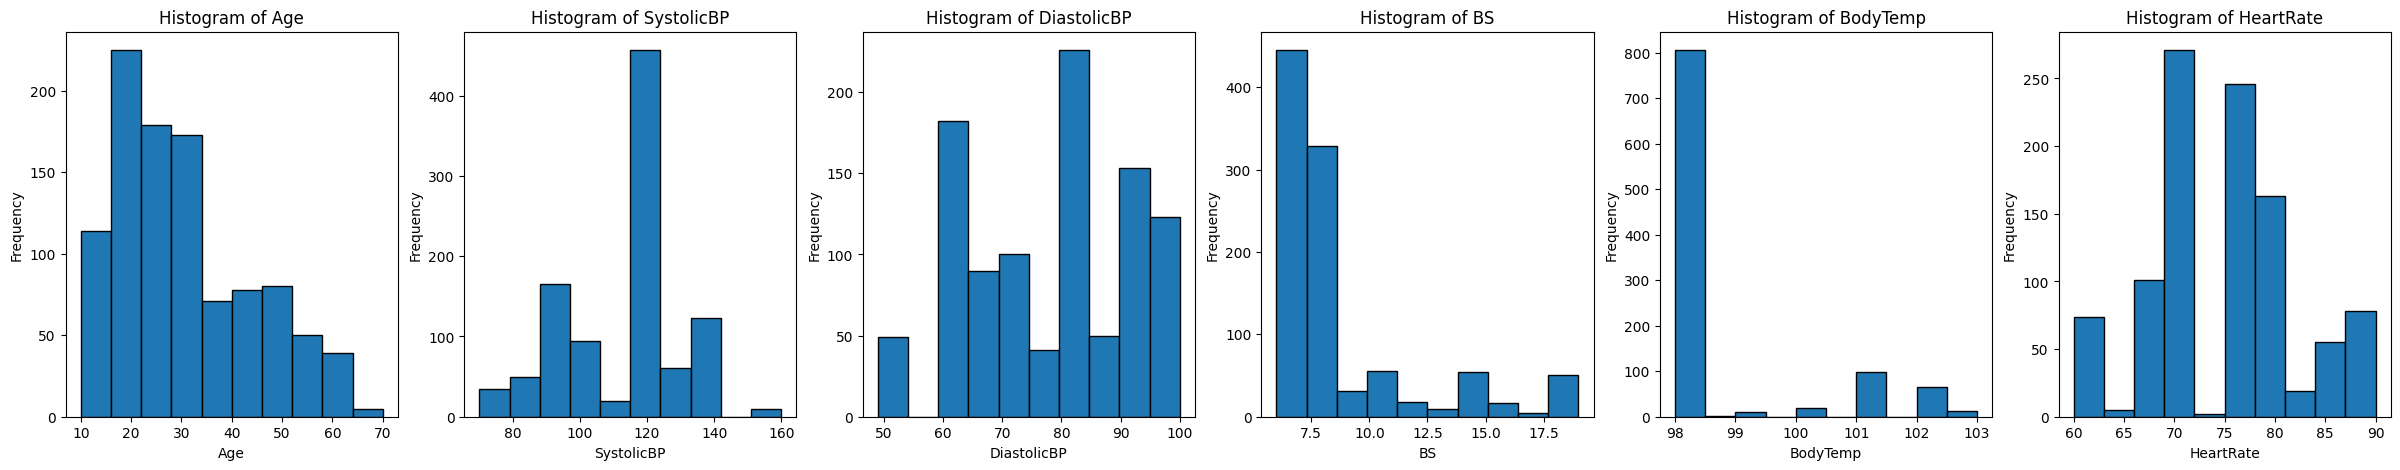

In [13]:
# Call the histogram_subplot funtion on the dataframe with the specified columns
plot_histograms_subplots(df, cols)

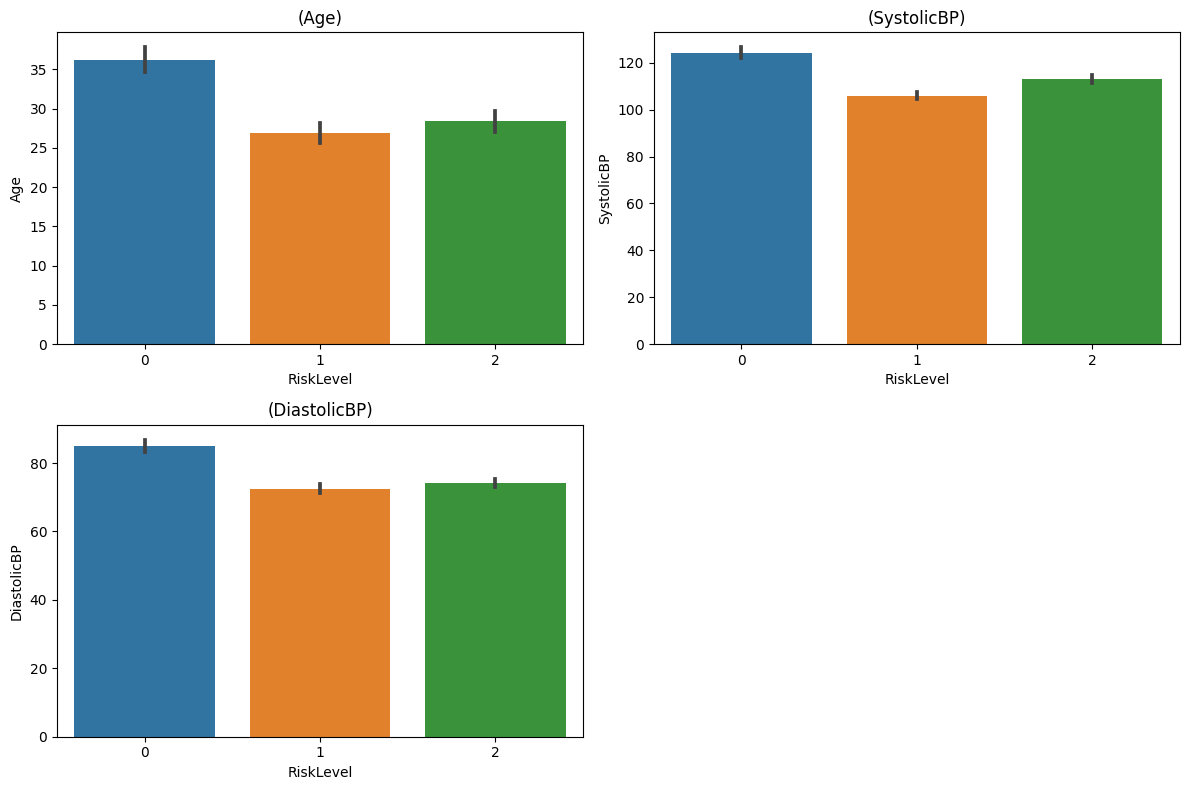

In [14]:
#Call the bar_subplots funtion passing the dataframe, x_col and list of y_cols to include in subplots
plot_bar_subplots(df, 'RiskLevel', ['Age', 'SystolicBP','DiastolicBP'], [0, 1, 2])

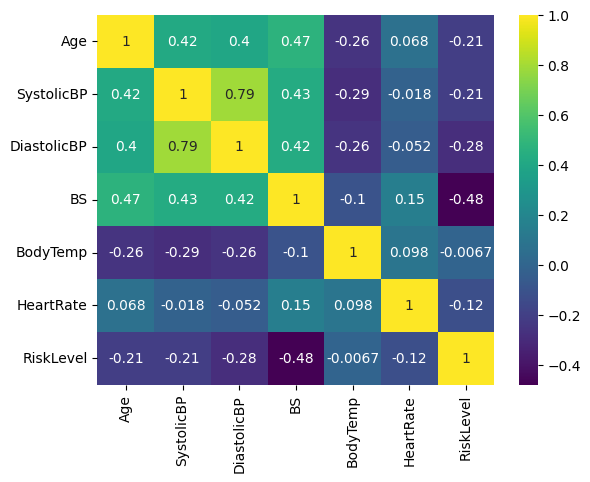

In [15]:
# Plotting correlation matrix to show relationship strength (same as plotting pairplots)
plt.figure(dpi=100)
#sns.heatmap(df.corr(), annot=True, cmap='cyan')
sns.heatmap(df.corr(), annot=True, cmap='viridis')
# Display plot
plt.show()

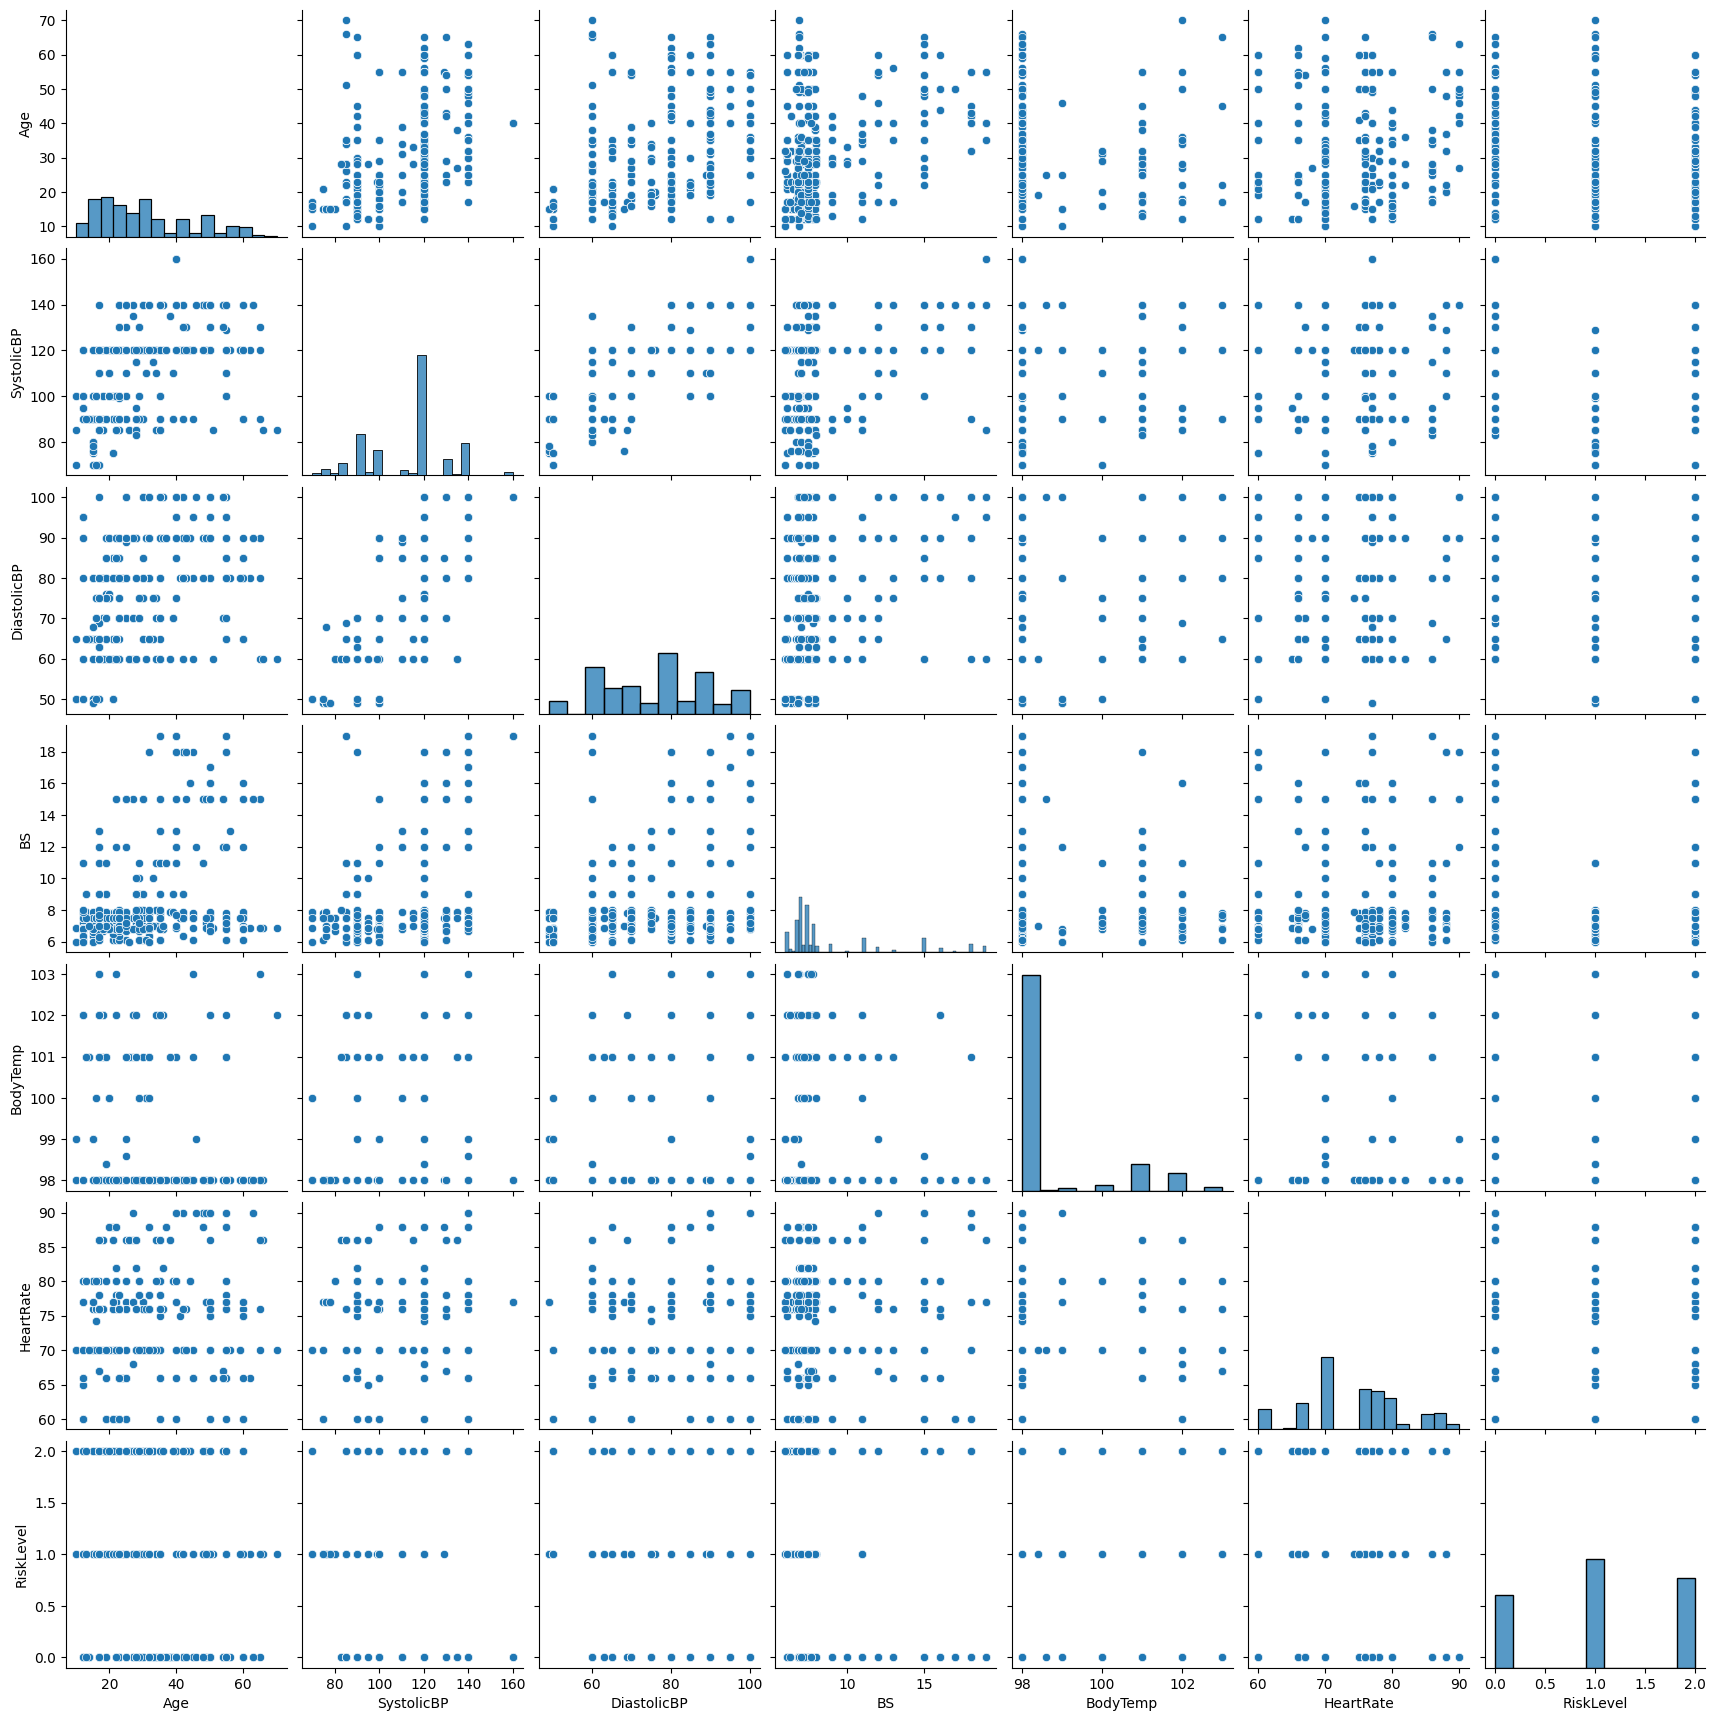

In [16]:
#Creating pairplots to show relationships between dataframe columns
sns.pairplot(df)
plt.show()

<Axes: >

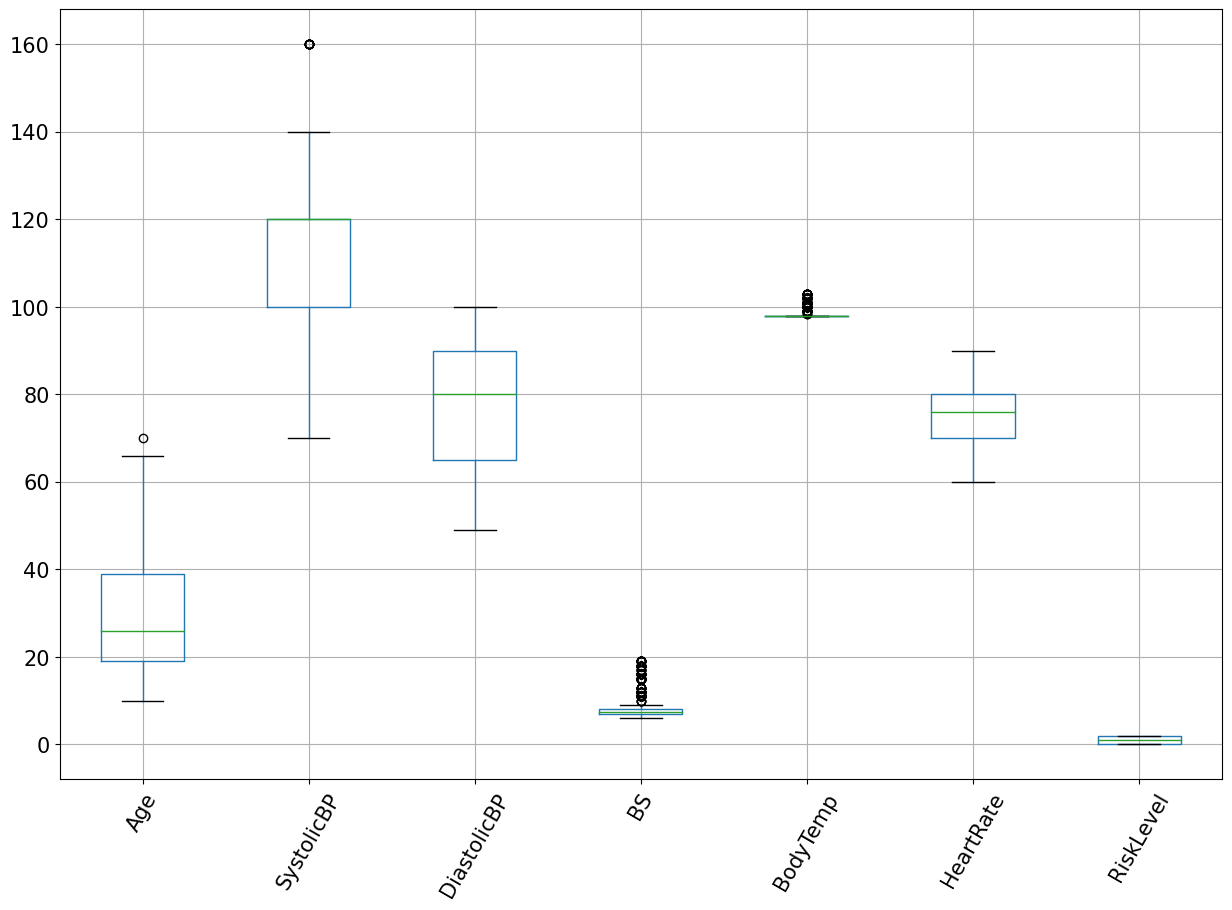

In [17]:
df.boxplot(figsize = (15,10), fontsize = 15, rot = 60)

### 1. BUILD A LINEAR MODEL

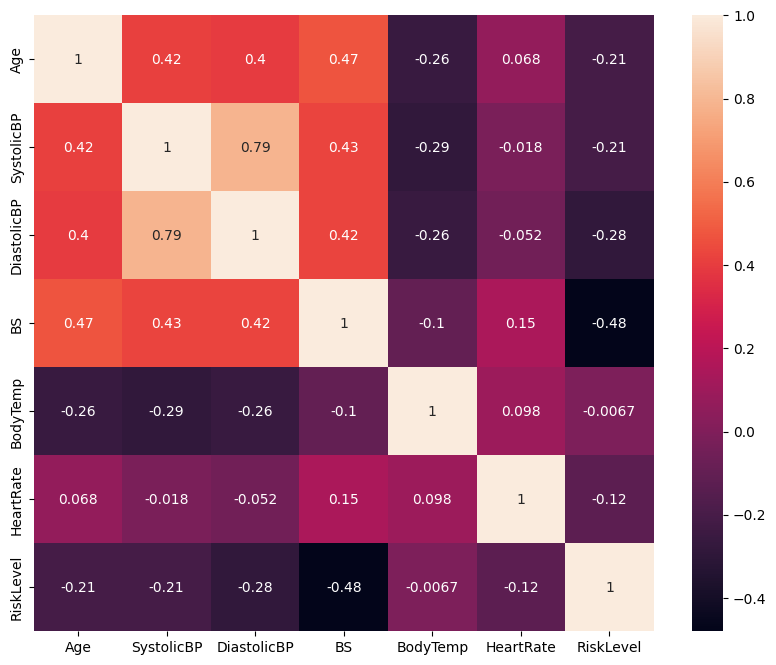

In [18]:
#show correlation coefficient of the features
plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(df.corr(), annot=True)
plt.show()

#### BUILD LINEAR MODEL

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop('SystolicBP', axis=1)
y = df['SystolicBP']

In [20]:
selected_features = ['DiastolicBP', 'Age', 'BS']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

#### USING THE SELECTED VARIABLES TO PREDICT SYSTOLICBP

In [22]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

r2 = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_error(y_test, y_pred)
mean_sqr_err = mean_squared_error(y_test, y_pred)
root_mean_sqr = np.sqrt(mean_sqr_err)

In [23]:
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error: {mean_abs_err:.2f}")
print(f"Root Mean Square Error: {root_mean_sqr:.2f}")

R2 Score: 0.62
Mean Absolute Error: 8.87
Root Mean Square Error: 11.09


### 2. PCA

In [24]:

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

X_std_df = pd.DataFrame(X_std, columns=X.columns)
X_std_df

,Age,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,-0.361738,0.255023,1.905890,-0.485215,1.539862,-1.377512
1,0.380777,0.975539,1.298340,-0.485215,-0.590425,-1.377512
2,-0.064732,-0.465493,-0.220537,0.973884,0.741004,-1.377512
3,0.009519,0.615281,-0.524312,-0.485215,-0.590425,-1.377512
4,0.380777,-1.186009,-0.797710,-0.485215,0.208433,-0.081782
...,...,...,...,...,...,...
1009,-0.584493,-1.186009,1.905890,-0.485215,0.741004,-1.377512
1010,1.865807,0.975539,2.817216,-0.485215,-1.921855,-1.377512
1011,0.380777,-1.186009,3.120991,-0.485215,1.539862,-1.377512
1012,0.974789,0.975539,2.817216,-0.485215,-0.590425,-1.377512


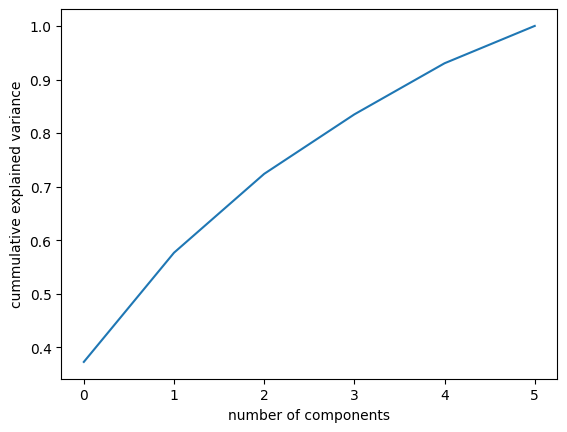

In [25]:
pca=PCA().fit(X_std_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cummulative explained variance')
plt.show()

In [26]:
pca=PCA(n_components=2)
new_data= pca.fit_transform(X_std_df)
new_df = pd.DataFrame(new_data, columns=['PC1','PC2'])
new_df

,PC1,PC2
0,1.808993,1.542516
1,1.988862,-0.161237
2,0.031722,1.630264
3,0.645000,-0.398382
4,-0.651670,-0.078084
...,...,...
1009,0.929915,1.410605
1010,3.411670,-0.875907
1011,2.134619,2.018972
1012,3.102526,0.066550


In [27]:
new_df['SystolicBP'] = df['SystolicBP']
new_df

,PC1,PC2,SystolicBP
0,1.808993,1.542516,130
1,1.988862,-0.161237,140
2,0.031722,1.630264,90
3,0.645000,-0.398382,140
4,-0.651670,-0.078084,120
...,...,...,...
1009,0.929915,1.410605,120
1010,3.411670,-0.875907,120
1011,2.134619,2.018972,85
1012,3.102526,0.066550,120


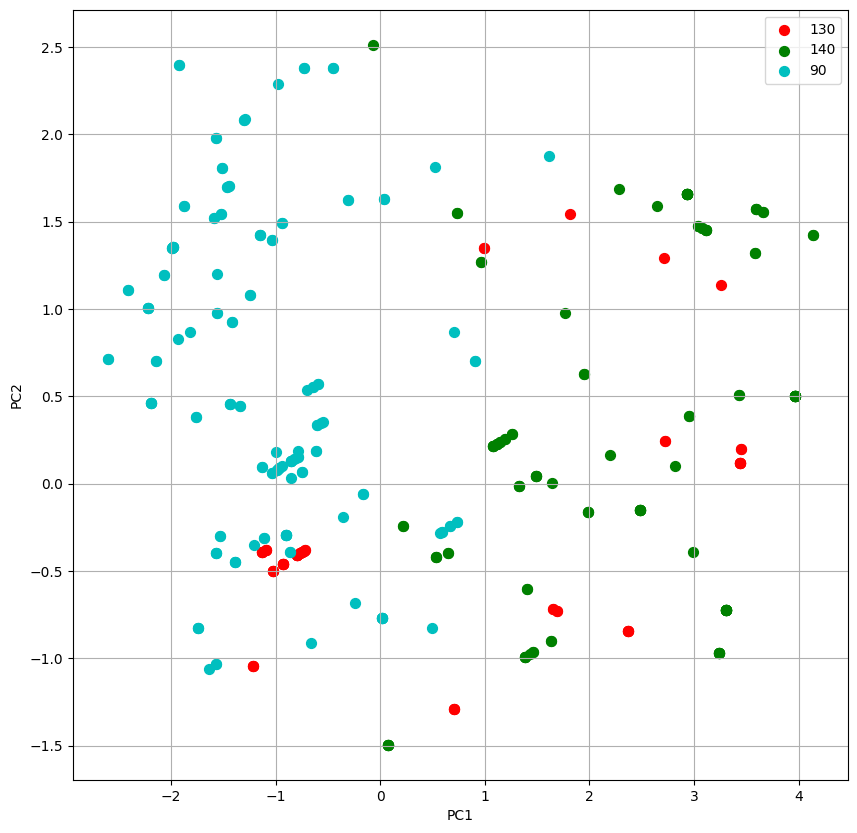

In [28]:
#Let's also visualize the outcome of the PCA.

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
targets = df['SystolicBP']
colors = ['r', 'g', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = new_df['SystolicBP'] == target
    ax.scatter(new_df.loc[indicesToKeep, 'PC1']
               , new_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=0.2, random_state=42)

In [30]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

r2 = r2_score(y_test, y_pred)
mean_abs_err = mean_absolute_error(y_test, y_pred)
mean_sqr_err = mean_squared_error(y_test, y_pred)
root_mean_sqr = np.sqrt(mean_sqr_err)

In [31]:
print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error: {mean_abs_err:.2f}")
print(f"Root Mean Square Error: {root_mean_sqr:.2f}")

R2 Score: 1.00
Mean Absolute Error: 0.00
Root Mean Square Error: 0.00


### 3. relationship between age and heartrate

In [32]:
new_df = df[['Age','HeartRate']]
new_df

,Age,HeartRate
0,25,86.0
1,35,70.0
2,29,80.0
3,30,70.0
4,35,76.0
...,...,...
1009,22,80.0
1010,55,60.0
1011,35,86.0
1012,43,70.0


In [33]:
bins= [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,120]
labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70+']
new_df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
new_df

C:\Users\711994\AppData\Local\Temp\ipykernel_13620\3330495097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)


,Age,HeartRate,AgeGroup
0,25,86.0,25-29
1,35,70.0,35-39
2,29,80.0,25-29
3,30,70.0,30-34
4,35,76.0,35-39
...,...,...,...
1009,22,80.0,20-24
1010,55,60.0,55-59
1011,35,86.0,35-39
1012,43,70.0,40-44


In [34]:
mean_heartrate = new_df.groupby("AgeGroup")["HeartRate"].mean()
mean_heartrate

AgeGroup
0-4            NaN
5-9            NaN
10-14    70.203704
15-19    73.593794
20-24    73.636872
25-29    77.937500
30-34    74.509091
35-39    73.803030
40-44    74.913043
45-49    82.288889
50-54    71.428571
55-59    74.000000
60-64    72.513514
65-69    79.500000
70+      70.000000
Name: HeartRate, dtype: float64

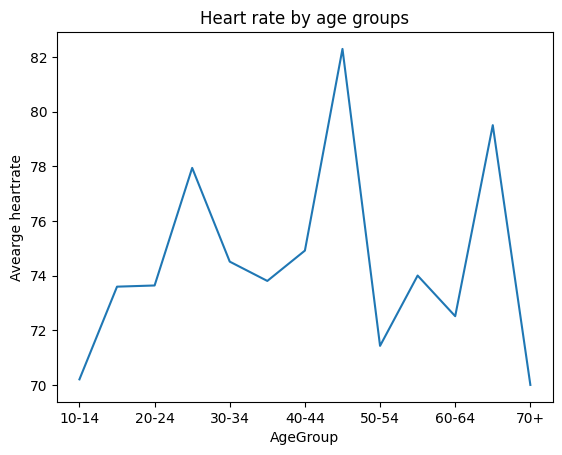

In [35]:
mean_heartrate.plot()
plt.title('Heart rate by age groups')
plt.ylabel('Avearge heartrate')
plt.show()

### 4. associations between pairs

In [36]:
new_df =df[['SystolicBP','DiastolicBP']]
new_df

,SystolicBP,DiastolicBP
0,130,80
1,140,90
2,90,70
3,140,85
4,120,60
...,...,...
1009,120,60
1010,120,90
1011,85,60
1012,120,90


In [37]:
labels = ['low','normal','high']
sysBP_bins= [0, 110, 140, 200]
diasBP_bins= [0, 70, 90, 200]

new_df['SystolicBP'] = pd.cut(new_df['SystolicBP'], bins=sysBP_bins, labels=labels, right=False)
new_df['DiastolicBP'] = pd.cut(new_df['DiastolicBP'], bins=diasBP_bins, labels=labels, right=False)
new_df

C:\Users\711994\AppData\Local\Temp\ipykernel_13620\2836405745.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['SystolicBP'] = pd.cut(new_df['SystolicBP'], bins=sysBP_bins, labels=labels, right=False)
C:\Users\711994\AppData\Local\Temp\ipykernel_13620\2836405745.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['DiastolicBP'] = pd.cut(new_df['DiastolicBP'], bins=diasBP_bins, labels=labels, right=False)


,SystolicBP,DiastolicBP
0,normal,normal
1,high,high
2,low,normal
3,high,normal
4,normal,low
...,...,...
1009,normal,low
1010,normal,high
1011,low,low
1012,normal,high


In [38]:
new_df = pd.get_dummies(new_df)
new_df

,SystolicBP_low,SystolicBP_normal,SystolicBP_high,DiastolicBP_low,DiastolicBP_normal,DiastolicBP_high
0,0,1,0,0,1,0
1,0,0,1,0,0,1
2,1,0,0,0,1,0
3,0,0,1,0,1,0
4,0,1,0,1,0,0
...,...,...,...,...,...,...
1009,0,1,0,1,0,0
1010,0,1,0,0,0,1
1011,1,0,0,1,0,0
1012,0,1,0,0,0,1


In [39]:
itemsets = apriori(new_df, min_support=0.001, use_colnames=True)

itemsets['cardinality'] = itemsets['itemsets'].map(lambda x: len(x))
itemsets

C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,cardinality
0,0.339250,(SystolicBP_low),1
1,0.532544,(SystolicBP_normal),1
2,0.128205,(SystolicBP_high),1
3,0.316568,(DiastolicBP_low),1
4,0.411243,(DiastolicBP_normal),1
5,0.272189,(DiastolicBP_high),1
6,0.266272,"(DiastolicBP_low, SystolicBP_low)",2
7,0.063116,"(DiastolicBP_normal, SystolicBP_low)",2
8,0.009862,"(DiastolicBP_high, SystolicBP_low)",2
9,0.050296,"(DiastolicBP_low, SystolicBP_normal)",2


In [40]:
rules = association_rules(itemsets, metric='confidence', min_threshold=0.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(DiastolicBP_low),(SystolicBP_low),0.316568,0.339250,0.266272,0.841121,2.479352,0.158876,4.158835,0.873048
1,(SystolicBP_low),(DiastolicBP_low),0.339250,0.316568,0.266272,0.784884,2.479352,0.158876,3.177035,0.903018
2,(SystolicBP_normal),(DiastolicBP_normal),0.532544,0.411243,0.335306,0.629630,1.531042,0.116301,1.589645,0.741996
3,(DiastolicBP_normal),(SystolicBP_normal),0.411243,0.532544,0.335306,0.815348,1.531042,0.116301,2.531545,0.589122
4,(SystolicBP_normal),(DiastolicBP_high),0.532544,0.272189,0.146943,0.275926,1.013728,0.001990,1.005160,0.028970
5,(DiastolicBP_high),(SystolicBP_normal),0.272189,0.532544,0.146943,0.539855,1.013728,0.001990,1.015888,0.018606
6,(DiastolicBP_high),(SystolicBP_high),0.272189,0.128205,0.115385,0.423913,3.306522,0.080489,1.513304,0.958446
7,(SystolicBP_high),(DiastolicBP_high),0.128205,0.272189,0.115385,0.900000,3.306522,0.080489,7.278107,0.800151


### 5. clusters

In [41]:
X = np.array(df['SystolicBP']).reshape(-1, 1)

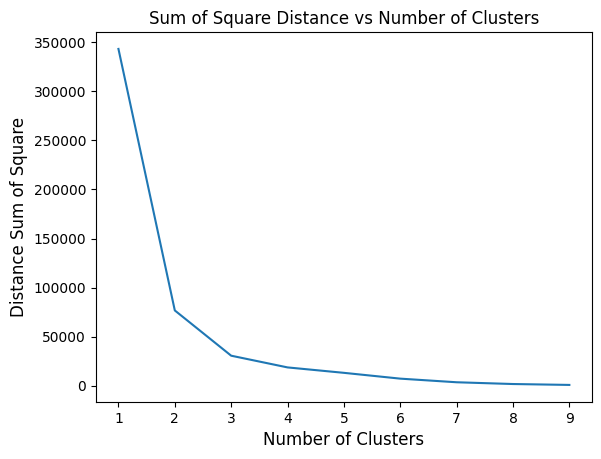

In [42]:
ss_distance = []
K = range(1, 10)
for clusters in K:
    K_means_clusters = KMeans(n_clusters = clusters, n_init=3, random_state = 25)
    K_means_clusters.fit(X)
    ss_distance.append(K_means_clusters.inertia_)

plt.title('Sum of Square Distance vs Number of Clusters')   
plt.plot(K, ss_distance)
plt.xlabel('Number of Clusters' ,fontsize='12')
plt.ylabel('Distance Sum of Square', fontsize='12')
plt.show()

In [43]:
kmeans = KMeans(n_clusters=3, random_state=0)
df['labels'] = kmeans.fit_predict(X)
df

C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,labels
0,25,130,80,15.0,98.0,86.0,0,0
1,35,140,90,13.0,98.0,70.0,0,0
2,29,90,70,8.0,100.0,80.0,0,2
3,30,140,85,7.0,98.0,70.0,0,0
4,35,120,60,6.1,98.0,76.0,1,1
...,...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80.0,0,1
1010,55,120,90,18.0,98.0,60.0,0,1
1011,35,85,60,19.0,98.0,86.0,0,2
1012,43,120,90,18.0,98.0,70.0,0,1


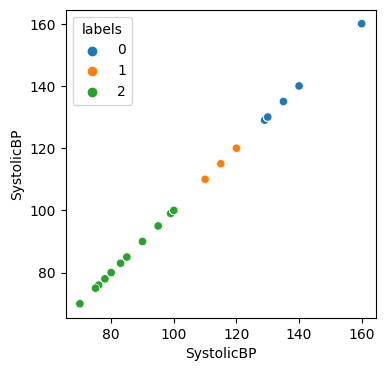

In [44]:
plt.figure(figsize=(4,4),dpi=100)
sns.scatterplot(data=df, x=df['SystolicBP'],y=df['SystolicBP'],hue=df['labels'] ,palette='tab10')
plt.show()

In [45]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)
silhouette_avg = silhouette_score(X, cluster_labels)
dbs = davies_bouldin_score(X, cluster_labels)

print('Silhouette score =', silhouette_avg)
print('Davies Bouldin score =', dbs)

Silhouette score = 0.7958849075878032
Davies Bouldin score = 0.24620996525268693


C:\Users\711994\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterNode


In [47]:
matrix_linkage = hierarchy.linkage(kmeans.cluster_centers_) # hierarchy is used to obtain the clusters
matrix_linkage # distances between the points 

array([[ 0.        ,  2.        , 20.68520463,  2.        ],
       [ 1.        ,  3.        , 30.12728444,  3.        ]])

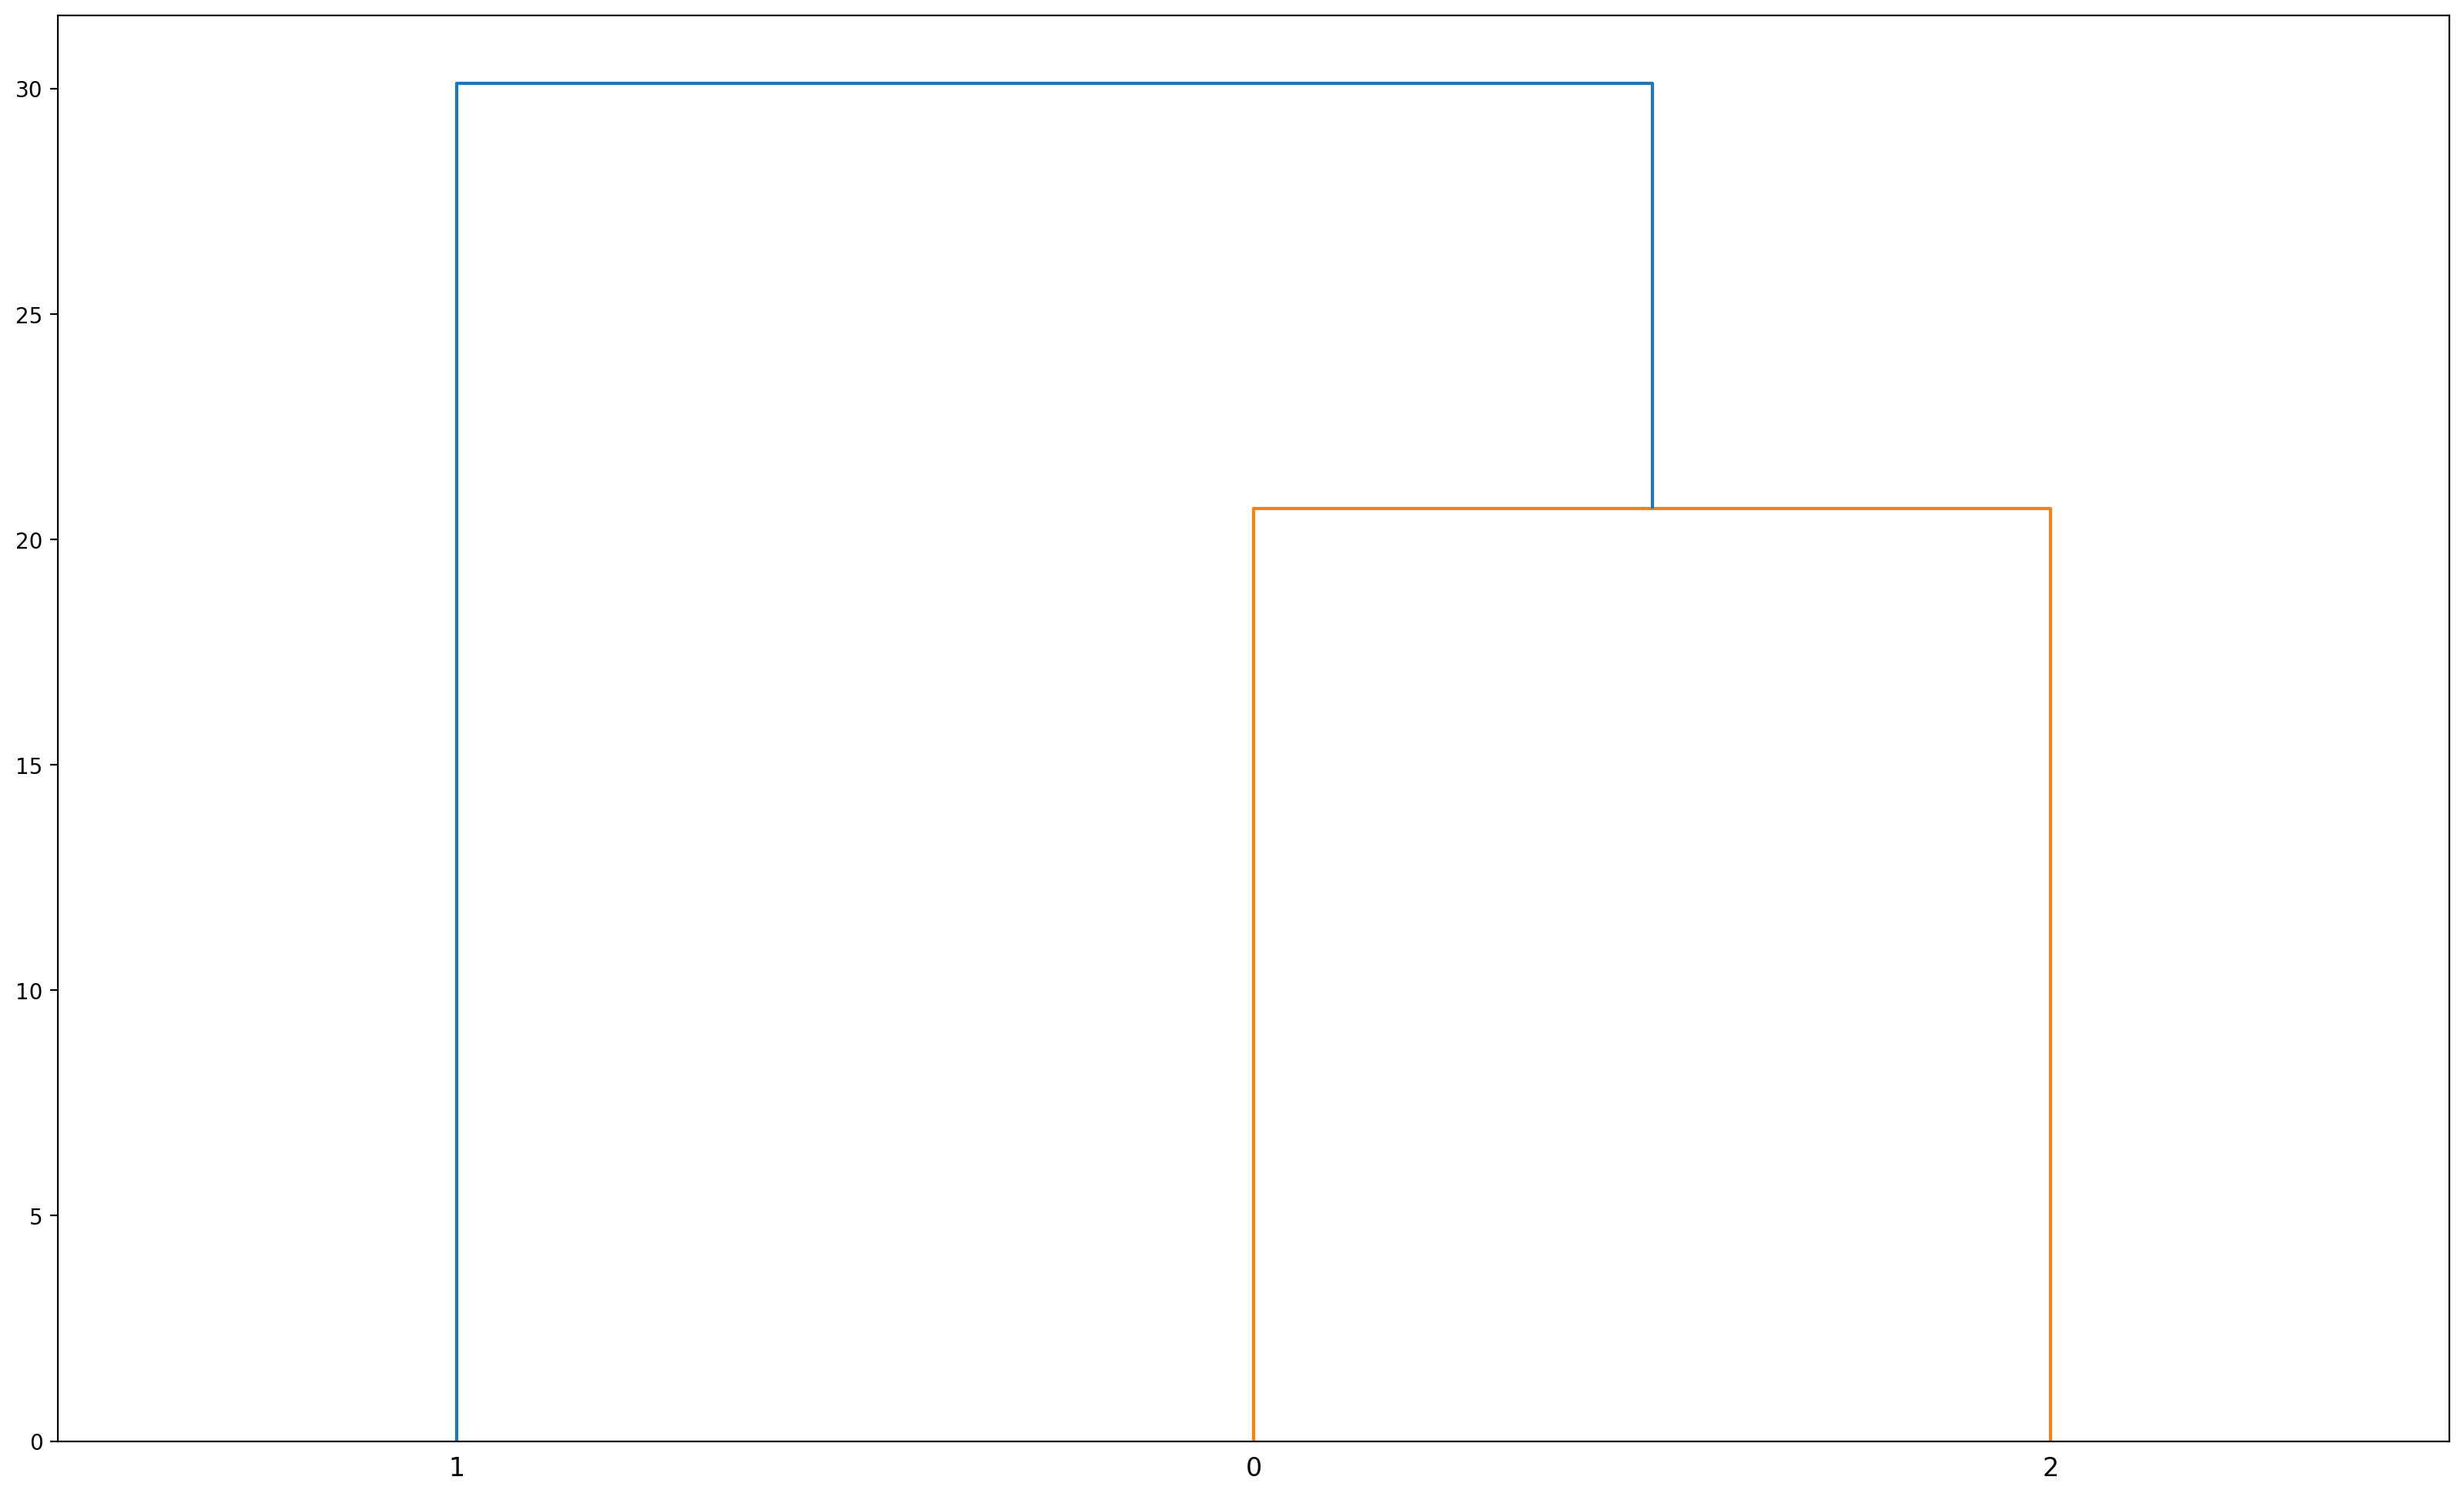

In [48]:
plt.figure(figsize=(20,12), dpi = 200,)
dendrogram(Z=matrix_linkage,truncate_mode= 'level', p= 7);

### 6. correlation between age and systolic BP

In [49]:
corr = df[['Age','SystolicBP']].corr()
corr

,Age,SystolicBP
Age,1.000000,0.416045
SystolicBP,0.416045,1.000000


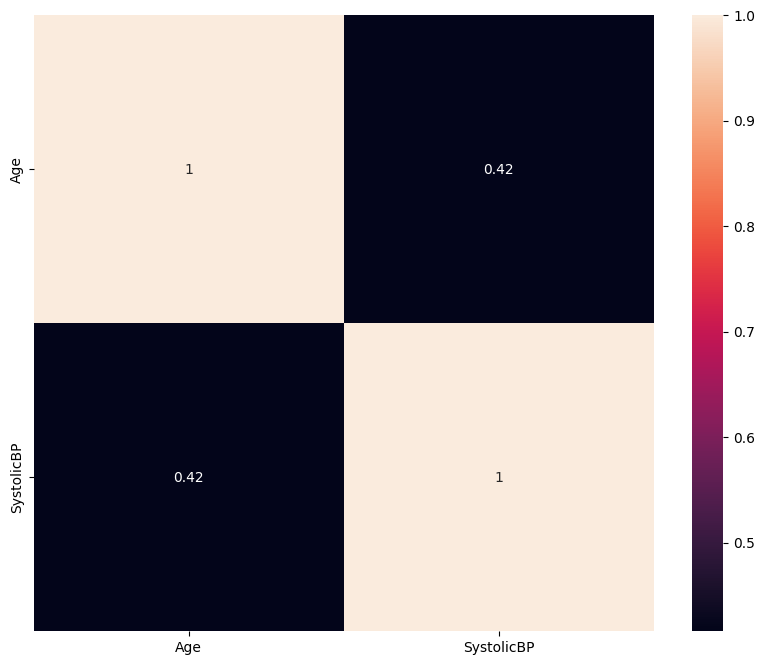

In [50]:
plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(corr, annot=True)
plt.show()